# Envisioning Dante - Graphics Detector

## 1 - Read Me First

This project is a [Jupyter](https://jupyter.org/) notebook and was
designed to run in [Google
Colab](https://colab.research.google.com/).  If you are not reading
this notebook in Google Colab, click
[here](https://colab.research.google.com/github/ox-vgg/demo-notebooks/blob/main/detectors/envdante-detector.ipynb).

### 1.1 - What is, and how to use, a Jupyter notebook

A Jupyter notebook is a series of "cells".  Each cell contains
either text (like this one) or code (like others below).  A cell
that contains code will have a "Run cell" button on the left side
like this "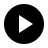".
When you click the "Run cell" button, the code in that cell will run
and when it finishes, a green check mark appears next to the "Run
cell" button".  You need to wait for the code in that cell to finish
before "running" the next cell.

### 1.2 - Particulars of this notebook

This notebook was designed to run in Google Colab and to analyse
images in Google Drive.  As such, it requires a Google account.

You must run the cells on this notebook one after the other since
each cell is dependent on the results of the previous cell.

### 1.3 - GPU access

A GPU is not required to run this program but without a GPU it will
run much slower.  Depending on the amount of data to analyse, it
might not be sensible to use it without a GPU>

By default, this notebook will run with a GPU.  However, it is
possible that you were not allocated one, typically because you've
used up all your GPU resources.  You can confirm this, and possibly
change it, manually.  To do that, navigate to "Edit" -> "Notebook
Settings" and select "GPU" from the "Hardware Accelerator" menu.

## 2 - Setup

### 2.1 - Check for GPU access

In [ ]:
#@markdown By default, this notebook will run with a GPU.  However, it
#@markdown is possible that you were not allocated one.  If you get a
#@markdown message saying that you do not have access to a GPU,
#@markdown navigate to "Edit" -> "Notebook Settings" and select "GPU"
#@markdown from the "Hardware Accelerator" menu.  If you change it,
#@markdown you need to run this cell again.

# We do this before everything else, namely before installing
# detectron2 (which takes a lot of time), to identify early the case
# of accidentally running this without a GPU.
import torch.cuda

if torch.cuda.is_available():
    USE_GPU = True
    print("You are using this GPU:")
    print(
        "GPU %d: %s (%d GB)"
        % (
            torch.cuda.current_device(),
            torch.cuda.get_device_name(),
            torch.cuda.get_device_properties(
                torch.cuda.current_device()
            ).total_memory
            * 1e-9,
        )
    )
else:
    USE_GPU = False
    print("You are NOT connected to a GPU")
    print("Consider reconnecting to a runtime with GPU access.")

### 2.2 - Install dependencies

In [ ]:
#@markdown This step can take a few of minutes to finish.

# Detectron2 is not available on PyPI, we have to install it from
# their git repos.

# Using `pip install --quiet` is not enough, it still prints out a
# mysterious "Preparing metadata (setup.py)" message which is why we
# redirect stdout to `/dev/null`.  Important messages should go to
# stderr anyway.
!pip install --quiet git+https://github.com/facebookresearch/detectron2.git > /dev/null

### 2.3 - Settings

In [ ]:
#@markdown When the model detects something, that detection is
#@markdown made with a confidence score between 0 and 100%.
#@markdown Detections with a confidence score lower than the selected
#@markdown threshold will be discarded.

CONFIDENCE_THRESHOLD = 50  #@param {type: "slider", min: 0, max: 100, step: 1}
CONFIDENCE_THRESHOLD /= 100.0

# In the future we can make these options but at the moment we only have
# these anyway.
DETECTRON2_CONFIG = "https://thor.robots.ox.ac.uk/staging/env-dante/mask-rcnn-R-50-FPN-D526v2-2024-03-12.py"
MODEL_CKPT = "https://thor.robots.ox.ac.uk/staging/env-dante/mask-rcnn-R-50-FPN-D526v2-2024-03-12.pth"

### 2.4 - Load dependencies and configure

In [ ]:

#@markdown This cell prepares the detector to run.  This is the place
#@markdown to make changes to the code if you want (but you should not
#@markdown need to).

import logging
import time

import PIL.Image
import detectron2.checkpoint
import detectron2.config
import detectron2.data
import detectron2.data.catalog
import detectron2.data.detection_utils
import detectron2.data.transforms
import detectron2.structures.masks
import detectron2.utils.visualizer
import numpy as np
import torch
import torch.utils.data

import google.colab.output
import google.colab.files
from google.colab.patches import cv2_imshow


_logger = logging.getLogger()
logging.basicConfig()


class Detectron2DatasetFromFilelist(torch.utils.data.Dataset):
    def __init__(self, fpath_list):
        super().__init__()
        self._fpath_list = fpath_list

    def __len__(self):
        return len(self._fpath_list)

    def __getitem__(self, idx):
        return {"file_name": self._fpath_list[idx]}


def build_model(cfg):
    model = detectron2.config.instantiate(cfg.model)
    model = model.to(cfg.train.device)
    checkpointer = detectron2.checkpoint.DetectionCheckpointer(model)
    checkpointer.load(cfg.train.init_checkpoint)
    return model


def build_thing_colours(metadata, thing_name_to_colour_name):
    thing_colours = {}
    for i, thing_name in enumerate(metadata.thing_classes):
        colour_name = thing_name_to_colour_name[thing_name]
        rgb = tuple([x / 255.0 for x in PIL.ImageColor.getrgb(colour_name)])
        thing_colours[i] = rgb
    return thing_colours


def pred_classes_to_colours(pred_classes, metadata):
    return [metadata.thing_colors[i] for i in pred_classes.tolist()]


def pred_classes_to_labels(pred_classes, metadata):
    return [metadata.thing_classes[i] for i in pred_classes.tolist()]


def pred_boxes_to_masks(boxes):
    """Convert Boxes to PolygonMasks because the Visualizer only shows
    boxes boundaries but want to "fill" the boxes.
    """
    masks = []
    for box in np.asarray(boxes.to("cpu")):
        masks.append([np.array([
            box[0], box[3],
            box[2], box[3],
            box[2], box[1],
            box[0], box[1]
        ])])
    return detectron2.structures.masks.PolygonMasks(masks)


def transform_boxes(augmentations, original_width, original_height, boxes):
    """Convert Boxes coordinates from one image size to another."""
    aug_input = detectron2.data.transforms.AugInput(
        np.ndarray((original_width, original_height)), boxes=boxes.to("cpu")
    )
    transform = augmentations(aug_input)  # in place transform
    del transform
    return detectron2.structures.Boxes(aug_input.boxes).to(boxes.device)


def show_instance_predictions(
    input, output, augmentations, metadata, score_thresh
):
    instances = output["instances"].to("cpu")
    # The model saw a resized/transformed image (input["image"] ---
    # the transformation would have been applied by the dataloader).
    # The output predicted boxes are relative to the original image
    # size though.  Because we are showing the predictions on top of
    # the resized image we need to transform the boxes.  We could show
    # the boxes on the original image but: 1) we'd have to read the
    # image again; ad 2) showing the resized image highlights any
    # issues caused by the image transform.
    boxes = transform_boxes(
        augmentations,
        input["width"],
        input["height"],
        instances.pred_boxes
    )

    wanted = instances.scores > score_thresh
    boxes = boxes[wanted]
    masks = pred_boxes_to_masks(boxes)

    img = input["image"].numpy().transpose(1, 2, 0)
    vis = detectron2.utils.visualizer.Visualizer(
        img[:, :, ::-1],
        metadata=metadata,
        instance_mode=detectron2.utils.visualizer.ColorMode.SEGMENTATION,
    )
    vis_out = vis.overlay_instances(
        boxes=boxes,
        masks=masks,
        labels=pred_classes_to_labels(
            instances.pred_classes[wanted], metadata
        ),
        assigned_colors=pred_classes_to_colours(
            instances.pred_classes[wanted], metadata
        )
    )
    cv2_imshow(vis_out.get_image()[:, :, ::-1])


cfg = detectron2.config.LazyConfig.load(
    detectron2.utils.file_io.PathManager.get_local_path(DETECTRON2_CONFIG)
)
cfg.train.init_checkpoint = MODEL_CKPT
if USE_GPU:
    cfg.train.device = "cuda"
else:
    cfg.train.device = "cpu"

metadata = detectron2.data.catalog.MetadataCatalog.get(
    cfg.dataloader.test.dataset.names[0]
)

metadata.set(
    thing_colors=build_thing_colours(
        metadata,
        {
            "graphic": "blue",
            "initial-capital": "magenta",
            "manicules": "lime",
            "page-number": "purple",
            "poem": "green",
            "running-header": "red",
            "section-header": "orange",
            "sideletter": "brown",
            "sidenote": "yellow",
            "unpainted-guideletter": "violet",
            "catchword-signature": "cyan",
        }
    )
)


model = build_model(cfg)
model = model.eval()

## 3 - Run Detector

### 3.1 - Upload Images and Run Detector

In [ ]:
#@markdown When you run this cell, a "Browse..." button will appear at
#@markdown the bottom of the cell.  When you press it, a dialog to
#@markdown upload files will appear.  Select any number of images.
#@markdown When all selected images finish uploading, they will be
#@markdown evaluated one at a time, and the detection results
#@markdown displayed.

google.colab.output.no_vertical_scroll()

uploaded = google.colab.files.upload()
dataset = Detectron2DatasetFromFilelist(list(uploaded.keys()))
dataset_mapper = detectron2.config.instantiate(cfg.dataloader.test.mapper)
dataloader = detectron2.data.build_detection_test_loader(
    dataset, mapper=dataset_mapper, batch_size=1,
)

for inputs in dataloader:
    with torch.no_grad():
        start_compute_time = time.perf_counter()
        outputs = model(inputs)
        compute_time = time.perf_counter() - start_compute_time
        _logger.debug("Inference time: %f seconds", compute_time)
    for input, output in zip(inputs, outputs):
        show_instance_predictions(
            input,
            output,
            dataset_mapper.augmentations,
            metadata,
            CONFIDENCE_THRESHOLD
        )